# SCC-ICMC-USP - 1st. Semester - 2023
# SCC5948/MAI5024. Data Science - Final Work – **03.** Training and Test

### Prof. PhD. Roseli Aparecida Francelin Romero

### Monitor: Diogo Godoi

Group Number: 12

Students:

1.   Leandro Marcos da Silva (**13702000**)
2.   Vinícius Andreghetti (**9898012**)


## Imports

In [1]:
# Imports
from imblearn.over_sampling import SMOTE
from pathlib import Path
from pycaret.classification import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from time import time
from utils import split_X_y # utils.py

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pickle
import warnings
import xgboost as xgb
import pycaret


# Ignore Pandas warnings
warnings.filterwarnings("ignore")

# Random state default
RANDOM_STATE = 42

## Functions

In [2]:
def plot_roc_curve(model, fpr, tpr, roc_auc, k,
                   save_figure=False, reports_path=None, file_name=None):
    # Config the plot
    plt.figure(figsize=(10,10))
    plt.grid()
    plt.plot([0, 1], [0, 1], ls='--')
    plt.ylim([-0.01, 1.01])
    plt.xlim([-0.01, 1.01])
    plt.xlabel('False Positive Rate', size=16)
    plt.ylabel('True Positive Rate', size=16)

    linspace = np.linspace(0, 1, 100)

    # Calculate the mean ROC
    int_tpr = [np.interp(linspace, fpr[i], tpr[i]) for i in range(k)]
    mean_tpr = np.mean(int_tpr, axis=0)

    # Plot all ROC curves for each fold and the average ROC curve
    for i in range(k):
        plt.plot(fpr[i], tpr[i], label=f'fold {i + 1}, Area: {roc_auc[i]:.5f}')
    
    plt.plot(linspace, mean_tpr, label=f'Average Curve, Area: {auc(linspace, mean_tpr):.5f} (+/- {np.std(roc_auc)*2:.5f})')

    # Plot the graph
    plt.legend(prop={'size': 16})
    # Save the ROC curve
    plt.savefig(f'{reports_path}images/{file_name}-roc_curve.png')
    plt.show() # Show the plot



def plot_confusion_matrix(y_true, y_pred, class_names, normalized,
                          save_figure=False, reports_path=None, file_name=None):
    # Get confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize=normalized)
    # Confusion matrix display
    cm_p = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10,10)) # Plot size
    plt.rc('font', **{'size':14}) # Setting font size 
    cm_p.plot(ax=ax) # Confusion matrix plot show
    
    if save_figure == True: # Save figure
        plt.savefig(f'{reports_path}images/{file_name}-cm.png')



def classification_with_report(model, X, y, k, class_names, save_report=False,
                               reports_path=None, file_name=None, verbose=True):
    # Lists
    fpr, tpr, roc_auc = [], [], []
    original_label, predicted_label, predicted_proba = [], [], []
    
    # Stratified K-Fold cross-validation
    skf = StratifiedKFold(k)
    
    # Time counting
    start = time()
    
    # Train and test the model for each 'k' fold in all the data
    for train_index, test_index in skf.split(X,y):
        model.fit(X.iloc[train_index], y[train_index])
        y_pred_probability = model.predict_proba(X.iloc[test_index])

        # Predict to generate classification report
        y_pred = model.predict(X.iloc[test_index])
        predicted_label.extend(y_pred)
        original_label.extend(y[test_index])

        # Compute micro-average ROC curve and ROC area
        temp_fpr, temp_tpr, _ = roc_curve(y[test_index], y_pred_probability[:,1])
        fpr.append(temp_fpr)
        tpr.append(temp_tpr)
        roc_auc.append(auc(temp_fpr, temp_tpr))
     
    # Total time spent on training
    total_time = time() - start

    if verbose == True: # Show results
        # Results
        print('\t\t\tClassification Report\n\n')
        print(classification_report(original_label, predicted_label, target_names=class_names, digits=5))
        print('F1-Score: ' + str(round(f1_score(original_label, predicted_label), 5)))
        print('AUC: ' + str(round(np.mean(roc_auc), 5)))
        print('Total Time: ' + str(round(total_time, 5)) + ' seconds')
        print('Confusion Matrix:\n')
        # Plot the ROC curve
        plot_roc_curve(model, fpr, tpr, roc_auc, k)
        # Plot the confusion matrix
        plot_confusion_matrix(original_label, predicted_label, class_names, None)

    if save_report == True: # Save report
        # file_name (without extension)
        with open(reports_path + file_name + '.txt', 'a+') as f:
            f.write(type(model).__name__ + '\n ')
            f.write(str(model))
            f.write('\n\n\n')
            f.write('\t\t\tClassification Report\n\n')
            f.write(classification_report(original_label, predicted_label, target_names=class_names, digits=5))
            f.write('\n\nF1-Score: ' + str(round(f1_score(original_label, predicted_label), 5)))
            f.write('\nAUC: ' + str(round(np.mean(roc_auc), 5)))
            f.write('\nTotal Time: ' + str(round(total_time, 5)) + ' seconds\n\n')
            # Save the ROC curve
            plot_roc_curve(model, fpr, tpr, roc_auc, k,
                           save_figure=True, reports_path=reports_path, file_name=file_name)
            # Save the confusion matrix
            plot_confusion_matrix(original_label, predicted_label, class_names, None,
                                  save_figure=True, reports_path=reports_path, file_name=file_name)

    return model # Return trained model



def objective(trial, X, y, k):
    params = { # Hyperparameters that will be optimized
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
    }

    # Stratified K-Folds cross-validator
    skf = StratifiedKFold(k)
    scores = np.empty(k) # Save score of each fold

    # Train and validation the model for each 'k' fold
    for idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = lgb.LGBMClassifier(**params) # Start model
        # Train model
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)],
                  early_stopping_rounds=100,
        )

        # Predict the values based on the F1-score
        preds = model.predict(X_val)
        scores[idx] = f1_score(y_val, preds)

    return np.mean(scores)



def report_model(model, X, y, class_names, normalized='true'):
    # Predict to generate report
    y_pred = model.predict(X)

    # Results
    print('\t\t\tClassification Report\n\n')
    print(classification_report(y, y_pred, target_names=class_names, digits=5))
    print('F1-Score: ' + str(round((f1_score(y, y_pred)), 5)))
    # Confusion matrix
    print('\nConfusion Matrix:\n')
    plot_confusion_matrix(y, y_pred, class_names, normalized)



def save_object(obj, file_name):
    with open(f'{file_name}.pkl', 'wb') as f:
        pickle.dump(obj, f) # Save object with .pkl extension


        
def load_object(file_name):
    with open(f'{file_name}.pkl', 'rb') as f:
        loaded_obj = pickle.load(f) # Load object saved as .pkl
    
    return loaded_obj # Return loaded object



def lgb_plot_importance(booster, figsize, **kwargs):    
    # Create figure with size defined
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Bar chart with the importance of features
    return lgb.plot_importance(booster=booster, ax=ax, **kwargs)



def optimize_save_lgb(X, y, n_trials, k, models_path, reports_path, column_set):
    # Optimize LightGBM hyperparameters (selected algorithm)
    study = optuna.create_study(direction="maximize", study_name="lightgbm")
    func = lambda trial: objective(trial, X, y, k)
    # Setting the logging level CRITICAL
    optuna.logging.set_verbosity(optuna.logging.CRITICAL)
    study.optimize(func, n_trials=n_trials, n_jobs=-1)

    # Save the best parameters in a .pkl file
    save_object(study.best_params, f'{models_path}params_lgb_{column_set}')
    
    # Load the best parameters
    best_params = load_object(f'{models_path}params_lgb_{column_set}')
    
    for i in range(3): # Run three times to average the execution time
        # LightGBM (optimized)
        model = lgb.LGBMClassifier(**best_params)
        model = classification_with_report(model, X, y, 10, ['Normal', 'Evil Twin'],
                                           save_report=True, reports_path=reports_path,
                                           file_name=f'lgb_{column_set}_optimized', verbose=False)
        
    # Save optimized LightGBM model
    save_object(model, f'{models_path}lgb_{column_set}_optimized')
    # Load optimized LightGBM model
    model = load_object(f'{models_path}lgb_{column_set}_optimized')
    
    # Return the trained model
    return model



def get_df_column_set(df, numeric_columns, column_name):
    # DataFrame with column set
    return df[numeric_columns + list(df.filter(regex=column_name).columns)]

## Main


In [3]:
# General path
path = f'{str(Path.home())}/EvilTwin_detection/'
# Pre-processed data path
preprocessed_data_path = f'{path}data/pre_processed/'
# Path to save the models
models_path = f'{path}/models/'
# Path to save results
reports_path = f'{path}/reports/'

# Load pre-processed training dataset
train_df = pd.read_csv(preprocessed_data_path + 'train_data.csv')
# Load pre-processed test dataset
test_df = pd.read_csv(preprocessed_data_path + 'test_data.csv')

In [4]:
# Split train data into X and y
X_train, y_train = split_X_y(train_df)
# Split test data into X and y
X_test, y_test = split_X_y(test_df)

# Balance train data with SMOTE
X_res, y_res = SMOTE(random_state=RANDOM_STATE).fit_resample(X_train, y_train)

In [5]:
%%capture
# Not plot show

for i in range(3): # Run the algorithms three times to average the execution time
    # Compare algorithms
    models = dict() # Create dictionary to save each model

    # Decision Tree (default)
    models['dt'] = DecisionTreeClassifier(random_state=RANDOM_STATE)
    # Random Forest (default)
    models['rf'] = RandomForestClassifier(random_state=RANDOM_STATE)
    # Gaussian Naive Bayes (default)
    models['nb'] = GaussianNB()
    # Multi-Layer Perceptron (default)
    models['mlp'] = MLPClassifier(random_state=RANDOM_STATE)
    # XGBoost (default)
    models['xgb'] = xgb.XGBClassifier(verbosity=0, random_state=RANDOM_STATE)
    # LightGBM (default)
    models['lgb'] = lgb.LGBMClassifier(random_state=RANDOM_STATE)

    for model_acronym in models.keys(): # Train and validate each dataset in each algorithm
        _ = classification_with_report(models[model_acronym], X_res, y_res, 10, ['Normal', 'Evil Twin'],
                                       save_report=True, reports_path=reports_path,
                                       file_name=f'{model_acronym}_all', verbose=False)

In [6]:
%%capture
# Not plot show

# Optimize and save the model
model = optimize_save_lgb(X_res, y_res, 10, 5, models_path, reports_path, 'all')

[I 2023-05-11 09:23:11,086] A new study created in memory with name: lightgbm


[LightGBM] [Warning] feature_fraction is set=0.48202653220190594, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48202653220190594
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] lambda_l2 is set=4.75994464295827e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.75994464295827e-05
[LightGBM] [Warning] bagging_fraction is set=0.5760899904099943, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5760899904099943
[LightGBM] [Warning] lambda_l1 is set=5.678327855213672e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.678327855213672e-08
[LightGBM] [Warning] feature_fraction is set=0.9048332556298013, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9048332556298013
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=0.95440286

[LightGBM] [Warning] feature_fraction is set=0.9048332556298013, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9048332556298013
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=0.954402869708294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.954402869708294
[LightGBM] [Warning] bagging_fraction is set=0.3822476044074554, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3822476044074554
[LightGBM] [Warning] lambda_l1 is set=0.0010606423115683914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010606423115683914
[LightGBM] [Warning] feature_fraction is set=0.5306727718072077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5306727718072077
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l2 is set=0.0004547179634479

[LightGBM] [Warning] feature_fraction is set=0.9855378536345782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9855378536345782
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l2 is set=0.00282553581881055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00282553581881055
[LightGBM] [Warning] bagging_fraction is set=0.5325634622110781, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5325634622110781
[LightGBM] [Warning] lambda_l1 is set=4.0827948548288175e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0827948548288175e-05
[LightGBM] [Warning] feature_fraction is set=0.4078636797412005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4078636797412005
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=5.9317374345

[LightGBM] [Warning] feature_fraction is set=0.7885064401815735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7885064401815735
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l2 is set=0.02895490697628256, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02895490697628256
[LightGBM] [Warning] bagging_fraction is set=0.22006504749313313, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22006504749313313
[LightGBM] [Warning] lambda_l1 is set=2.012925619718374e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.012925619718374e-07
[LightGBM] [Warning] feature_fraction is set=0.9434321575249345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9434321575249345
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.0931361110

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

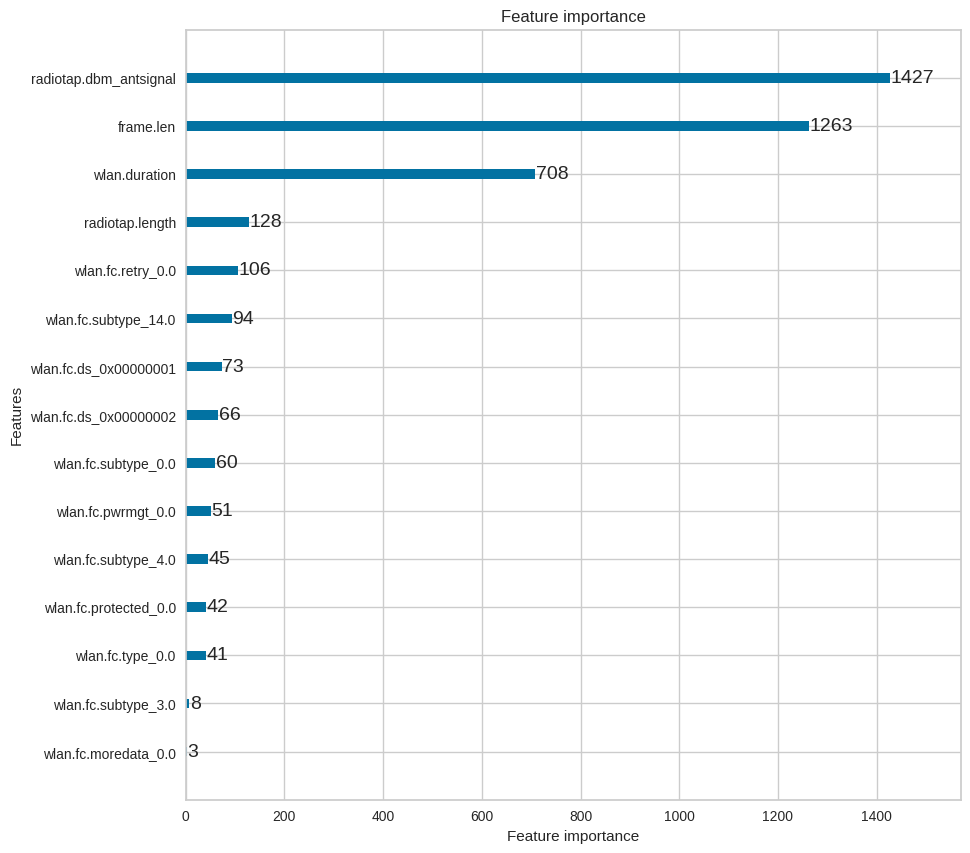

In [7]:
# Plot the importance of each feature on the trained model
lgb_plot_importance(model, (10, 10))

			Classification Report


              precision    recall  f1-score   support

      Normal    0.99996   0.99440   0.99717     24272
   Evil Twin    0.79822   0.99814   0.88706       539

    accuracy                        0.99448     24811
   macro avg    0.89909   0.99627   0.94211     24811
weighted avg    0.99558   0.99448   0.99478     24811

F1-Score: 0.88706

Confusion Matrix:



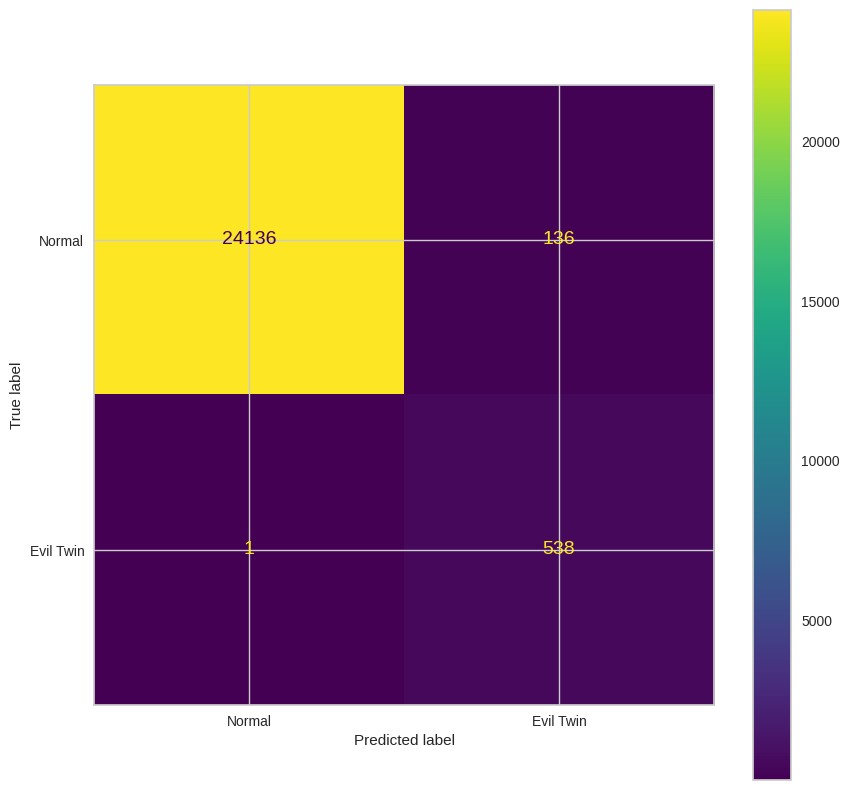

In [8]:
# LightGBM with optimized hyperparameters on test data
report_model(model, X_test, y_test, ['Normal', 'Evil Twin'], None)

### Training and test with column set

In [9]:
# Numeric columns
numeric_columns = ['frame.len', 'radiotap.dbm_antsignal', 'wlan.duration']

* **Set 1** - frame.len, radiotap.dbm_antsignal, wlan.duration, and *wlan.fc.subtype*:

In [10]:
# Select column set (wlan.fc.subtype)
X_res_set_1 = get_df_column_set(X_res, numeric_columns, 'wlan.fc.subtype')
X_test_set_1 = get_df_column_set(X_test, numeric_columns, 'wlan.fc.subtype')

In [11]:
%%capture
# Not plot show

# Optimize and save the model
model = optimize_save_lgb(X_res_set_1, y_res, 10, 5, models_path, reports_path, 'set_1')

[LightGBM] [Warning] feature_fraction is set=0.7560967725163955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7560967725163955
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=9.546361004570442e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.546361004570442e-07
[LightGBM] [Warning] bagging_fraction is set=0.971705711596723, subsample=1.0 will be ignored. Current value: bagging_fraction=0.971705711596723
[LightGBM] [Warning] lambda_l1 is set=2.2863825171640833e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2863825171640833e-08
[LightGBM] [Warning] feature_fraction is set=0.2137558289976123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2137558289976123
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=1.0442181820

[LightGBM] [Warning] feature_fraction is set=0.489200448748093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.489200448748093
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=0.0001583588443893146, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001583588443893146
[LightGBM] [Warning] bagging_fraction is set=0.4707121177524489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4707121177524489
[LightGBM] [Warning] lambda_l1 is set=3.539937138141842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.539937138141842
[LightGBM] [Warning] feature_fraction is set=0.7893845403190944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7893845403190944
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.005859310158003292, 

[LightGBM] [Warning] feature_fraction is set=0.5094268665411903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5094268665411903
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=0.00030683182318469226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00030683182318469226
[LightGBM] [Warning] bagging_fraction is set=0.7147574254434101, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7147574254434101
[LightGBM] [Warning] lambda_l1 is set=1.848109140243304e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.848109140243304e-08
[LightGBM] [Warning] feature_fraction is set=0.9770621149271814, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9770621149271814
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] lambda_l2 is set=1.250114

[LightGBM] [Warning] feature_fraction is set=0.6417089663954093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6417089663954093
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.009926387776675e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.009926387776675e-08
[LightGBM] [Warning] bagging_fraction is set=0.6695085730247071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6695085730247071
[LightGBM] [Warning] lambda_l1 is set=2.8146359646398835e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8146359646398835e-07
[LightGBM] [Warning] feature_fraction is set=0.7560967725163955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7560967725163955
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=9.54636100

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

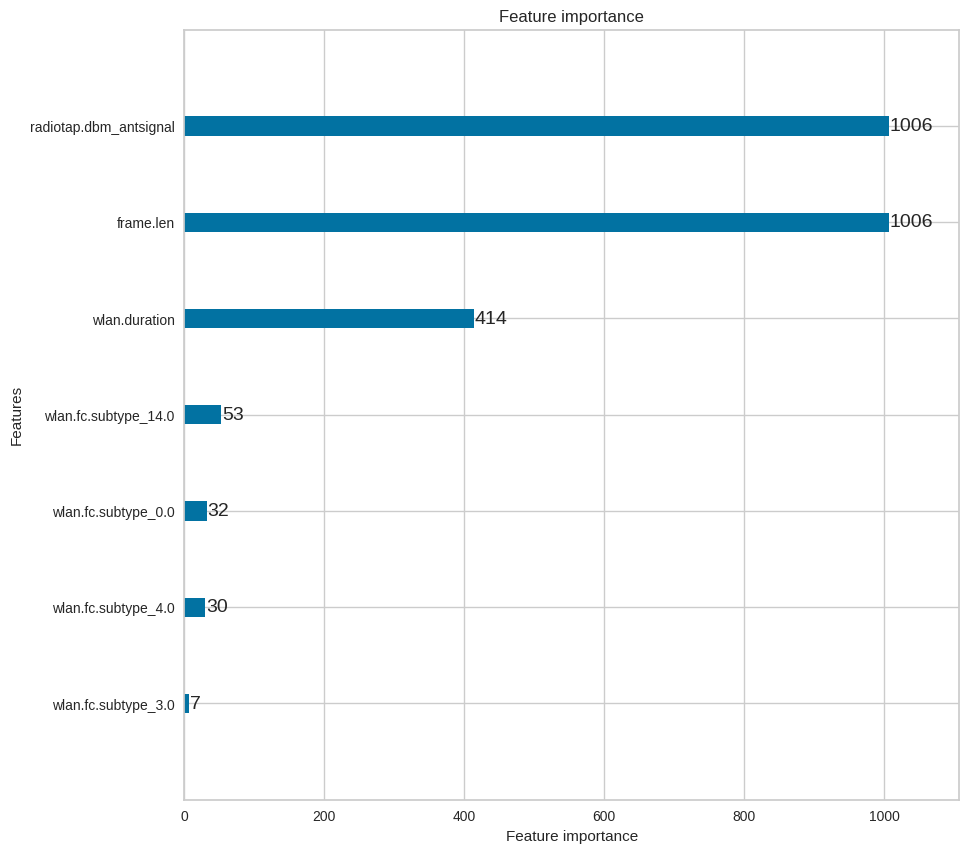

In [12]:
# Plot the importance of each feature on the trained model
lgb_plot_importance(model, (10, 10))

			Classification Report


              precision    recall  f1-score   support

      Normal    0.99979   0.97227   0.98584     24272
   Evil Twin    0.44242   0.99072   0.61168       539

    accuracy                        0.97267     24811
   macro avg    0.72110   0.98150   0.79876     24811
weighted avg    0.98768   0.97267   0.97771     24811

F1-Score: 0.61168

Confusion Matrix:



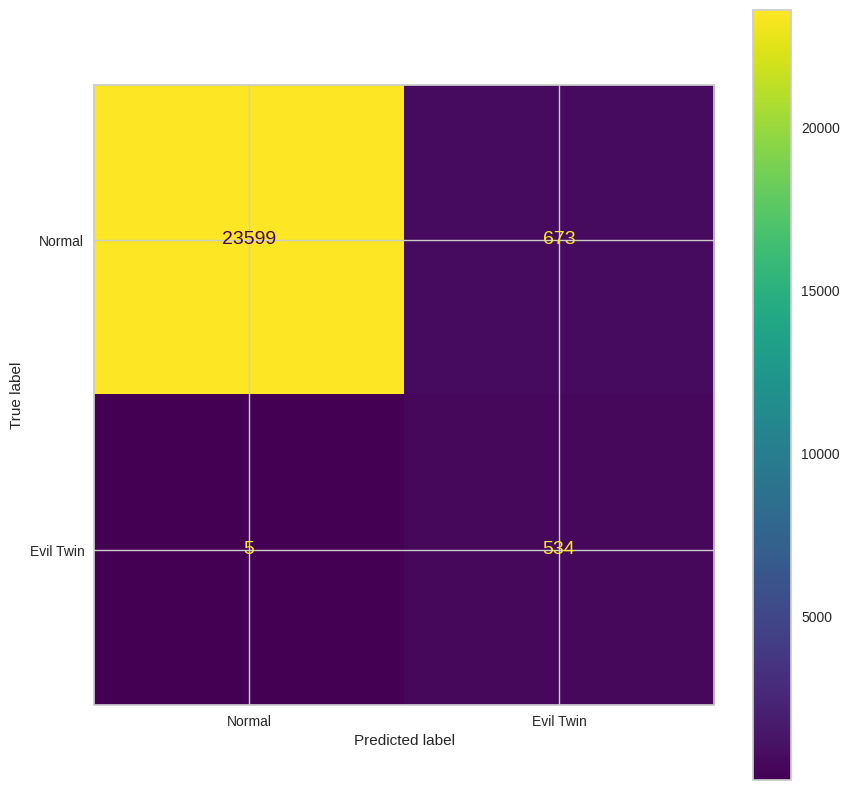

In [13]:
# LightGBM with optimized hyperparameters on test data
report_model(model, X_test_set_1, y_test, ['Normal', 'Evil Twin'], None)

* **Set 2** - frame.len, radiotap.dbm_antsignal, wlan.duration, and *wlan.fc.type*:

In [14]:
# Select column set (wlan.fc.type)
X_res_set_2 = get_df_column_set(X_res, numeric_columns, 'wlan.fc.type')
X_test_set_2 = get_df_column_set(X_test, numeric_columns, 'wlan.fc.type')

In [15]:
%%capture
# Not plot show

# Optimize and save the model
model = optimize_save_lgb(X_res_set_2, y_res, 10, 5, models_path, reports_path, 'set_2')

[LightGBM] [Warning] feature_fraction is set=0.11201808897729114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11201808897729114
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=0.0008873024836599473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008873024836599473
[LightGBM] [Warning] bagging_fraction is set=0.9644200715868209, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9644200715868209
[LightGBM] [Warning] lambda_l1 is set=4.538286233031957e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.538286233031957e-05
[LightGBM] [Warning] feature_fraction is set=0.9076276262017189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9076276262017189
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=6.009959

[LightGBM] [Warning] feature_fraction is set=0.21490260854486015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21490260854486015
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.7426624892762635e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7426624892762635e-08
[LightGBM] [Warning] bagging_fraction is set=0.3163217687798168, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3163217687798168
[LightGBM] [Warning] lambda_l1 is set=1.1112563386258854e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1112563386258854e-07
[LightGBM] [Warning] feature_fraction is set=0.30385842090472537, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30385842090472537
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=0.00

[LightGBM] [Warning] feature_fraction is set=0.9076276262017189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9076276262017189
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=6.009959429459313e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.009959429459313e-06
[LightGBM] [Warning] bagging_fraction is set=0.2395771157502763, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2395771157502763
[LightGBM] [Warning] lambda_l1 is set=9.757525712614154e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.757525712614154e-08
[LightGBM] [Warning] feature_fraction is set=0.47585508837012935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47585508837012935
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] lambda_l2 is set=0.0070

[LightGBM] [Warning] feature_fraction is set=0.12188702761613548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12188702761613548
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=0.16405551621241432, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16405551621241432
[LightGBM] [Warning] bagging_fraction is set=0.1435130131121068, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1435130131121068
[LightGBM] [Warning] lambda_l1 is set=0.09667745360098802, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09667745360098802
[LightGBM] [Warning] feature_fraction is set=0.21490260854486015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21490260854486015
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.74266248927626

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

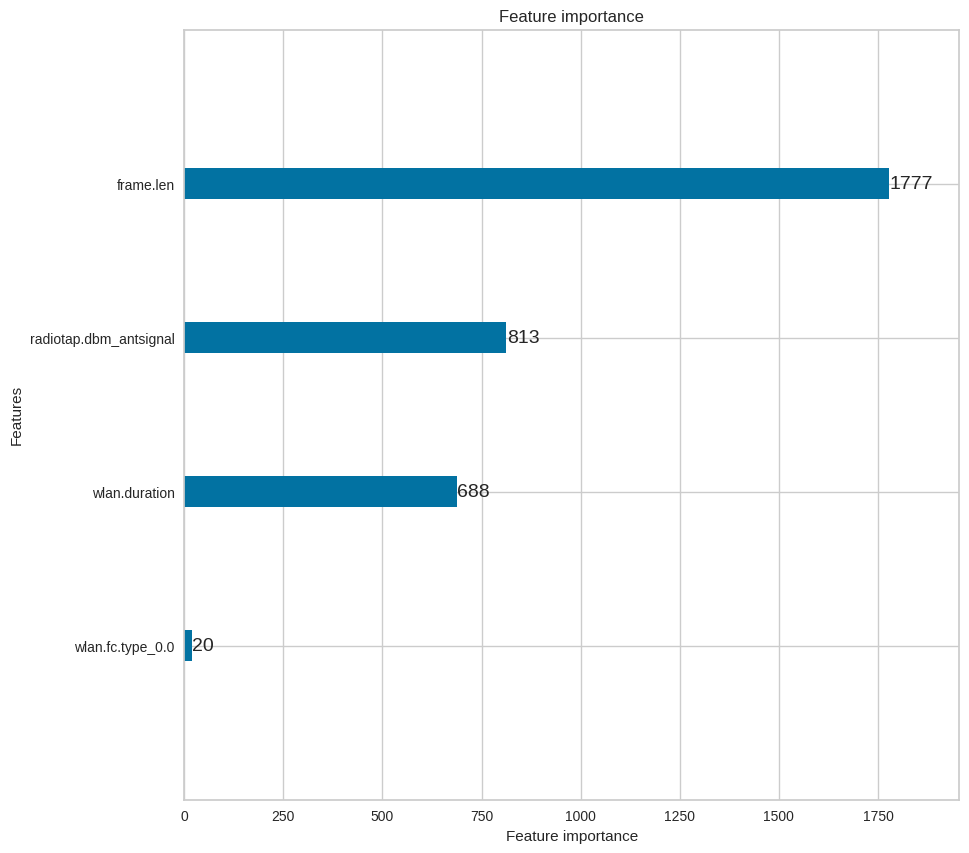

In [16]:
# Plot the importance of each feature on the trained model
lgb_plot_importance(model, (10, 10))

			Classification Report


              precision    recall  f1-score   support

      Normal    0.99970   0.97252   0.98592     24272
   Evil Twin    0.44370   0.98701   0.61220       539

    accuracy                        0.97283     24811
   macro avg    0.72170   0.97977   0.79906     24811
weighted avg    0.98762   0.97283   0.97781     24811

F1-Score: 0.6122

Confusion Matrix:



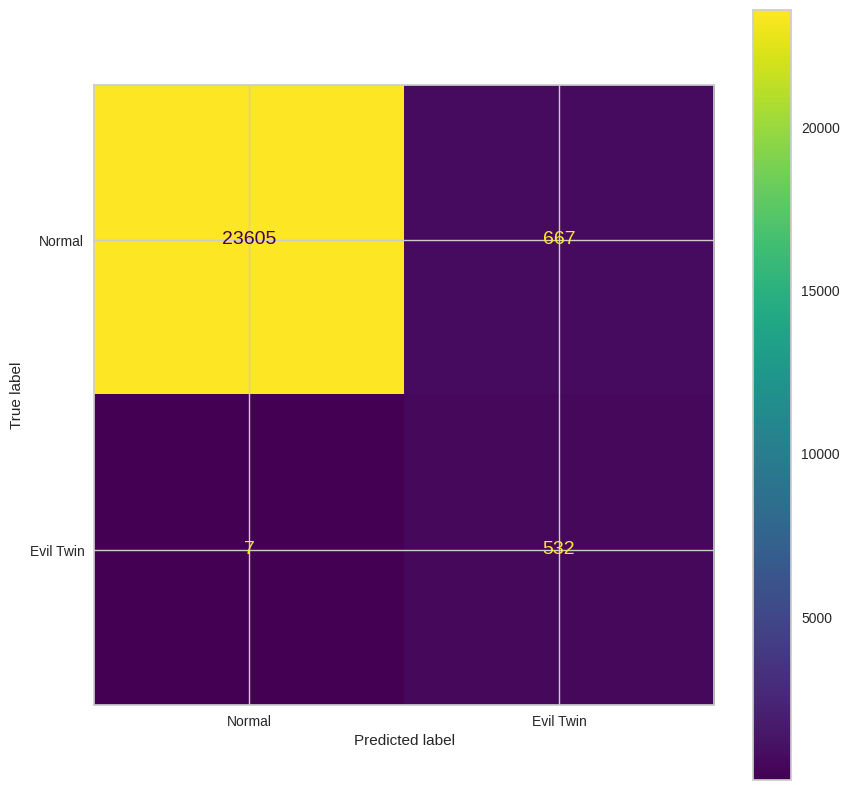

In [17]:
# LightGBM with optimized hyperparameters on test data
report_model(model, X_test_set_2, y_test, ['Normal', 'Evil Twin'], None)

* **Set 3** - frame.len, radiotap.dbm_antsignal, wlan.duration, and *wlan.fc.ds*

In [18]:
# Select column set (wlan.fc.ds)
X_res_set_3 = get_df_column_set(X_res, numeric_columns, 'wlan.fc.ds')
X_test_set_3 = get_df_column_set(X_test, numeric_columns, 'wlan.fc.ds')

In [19]:
%%capture
# Not plot show

# Optimize and save the model
model = optimize_save_lgb(X_res_set_3, y_res, 10, 5, models_path, reports_path, 'set_3')

[LightGBM] [Warning] feature_fraction is set=0.5893701199307687, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5893701199307687
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l2 is set=1.8945806969729188e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8945806969729188e-08
[LightGBM] [Warning] bagging_fraction is set=0.7784232383587127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7784232383587127
[LightGBM] [Warning] lambda_l1 is set=1.0411751313943836e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0411751313943836e-08
[LightGBM] [Warning] feature_fraction is set=0.5528663695831764, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5528663695831764
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=2.7813

[LightGBM] [Warning] feature_fraction is set=0.350771818477851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.350771818477851
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.36451102200283103, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.36451102200283103
[LightGBM] [Warning] bagging_fraction is set=0.6179577354279666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6179577354279666
[LightGBM] [Warning] lambda_l1 is set=0.6343007641781129, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6343007641781129
[LightGBM] [Warning] feature_fraction is set=0.15502804570604056, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15502804570604056
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=9.908536165411793e-06,

[LightGBM] [Warning] feature_fraction is set=0.2868496806549681, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2868496806549681
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] lambda_l2 is set=3.95399696397563e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.95399696397563e-06
[LightGBM] [Warning] bagging_fraction is set=0.7858836138944333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7858836138944333
[LightGBM] [Warning] lambda_l1 is set=8.12668193850443e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.12668193850443e-07
[LightGBM] [Warning] feature_fraction is set=0.91991242539731, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91991242539731
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=1.28523988679419

[LightGBM] [Warning] feature_fraction is set=0.37600919520569565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37600919520569565
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l2 is set=0.06703258007235827, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06703258007235827
[LightGBM] [Warning] bagging_fraction is set=0.15204993380438359, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15204993380438359
[LightGBM] [Warning] lambda_l1 is set=1.1720651208169763e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1720651208169763e-06
[LightGBM] [Warning] feature_fraction is set=0.5893701199307687, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5893701199307687
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l2 is set=1.8945

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

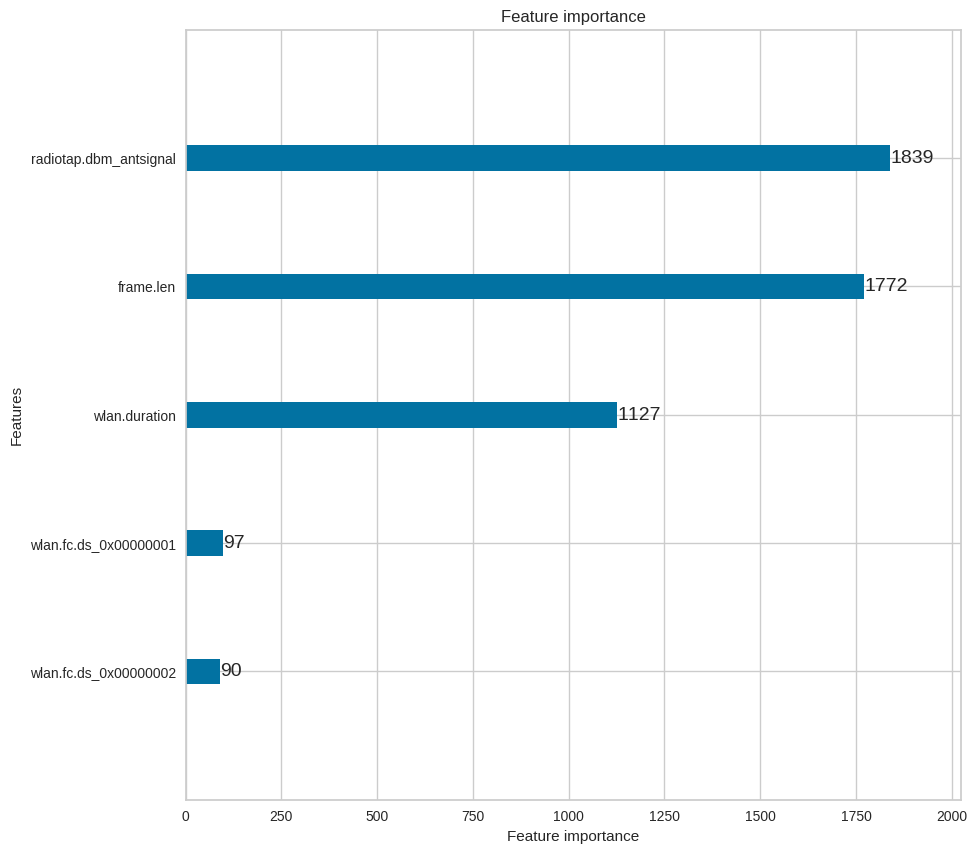

In [20]:
# Plot the importance of each feature on the trained model
lgb_plot_importance(model, (10, 10))

			Classification Report


              precision    recall  f1-score   support

      Normal    0.99979   0.97355   0.98649     24272
   Evil Twin    0.45408   0.99072   0.62274       539

    accuracy                        0.97392     24811
   macro avg    0.72694   0.98214   0.80462     24811
weighted avg    0.98793   0.97392   0.97859     24811

F1-Score: 0.62274

Confusion Matrix:



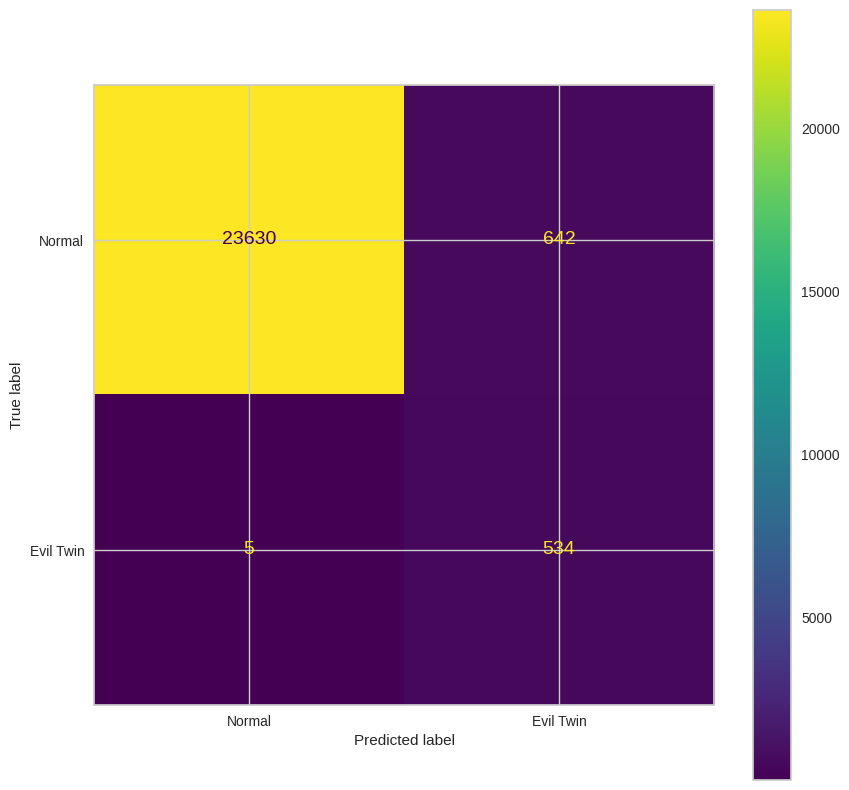

In [21]:
# LightGBM with optimized hyperparameters on test data
report_model(model, X_test_set_3, y_test, ['Normal', 'Evil Twin'], None)

* **Set 4** - frame.len, radiotap.dbm_antsignal, wlan.duration, and *wlan.fc.protected*

In [22]:
# Select column set (wlan.fc.protected)
X_res_set_4 = get_df_column_set(X_res, numeric_columns, 'wlan.fc.protected')
X_test_set_4 = get_df_column_set(X_test, numeric_columns, 'wlan.fc.protected')

In [23]:
%%capture
# Not plot show

# Optimize and save the model
model = optimize_save_lgb(X_res_set_4, y_res, 10, 5, models_path, reports_path, 'set_4')

[LightGBM] [Warning] feature_fraction is set=0.7089755962460467, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7089755962460467
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=7.650164130354037, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.650164130354037
[LightGBM] [Warning] bagging_fraction is set=0.9962924015541217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9962924015541217
[LightGBM] [Warning] lambda_l1 is set=4.873501222953567e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.873501222953567e-06
[LightGBM] [Warning] feature_fraction is set=0.9625276401128301, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9625276401128301
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.751797394953466e-0

[LightGBM] [Warning] feature_fraction is set=0.3125728919505941, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3125728919505941
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=1.0673708270228746e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0673708270228746e-05
[LightGBM] [Warning] bagging_fraction is set=0.9518470916845926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9518470916845926
[LightGBM] [Warning] lambda_l1 is set=1.2300099376625695e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2300099376625695e-07
[LightGBM] [Warning] feature_fraction is set=0.438520830588347, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.438520830588347
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l2 is set=3.954343

[LightGBM] [Warning] feature_fraction is set=0.3671437715435957, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3671437715435957
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] lambda_l2 is set=0.0002575558750595017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002575558750595017
[LightGBM] [Warning] bagging_fraction is set=0.1580504931789336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1580504931789336
[LightGBM] [Warning] lambda_l1 is set=2.7380934895169024e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7380934895169024e-05
[LightGBM] [Warning] feature_fraction is set=0.9579774083411811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9579774083411811
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=0.0008

[LightGBM] [Warning] feature_fraction is set=0.47869983280979467, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47869983280979467
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.3924777495736071e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3924777495736071e-05
[LightGBM] [Warning] bagging_fraction is set=0.43231260878774125, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43231260878774125
[LightGBM] [Warning] lambda_l1 is set=0.019953421773716236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019953421773716236
[LightGBM] [Warning] feature_fraction is set=0.3125728919505941, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3125728919505941
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=1.067370

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

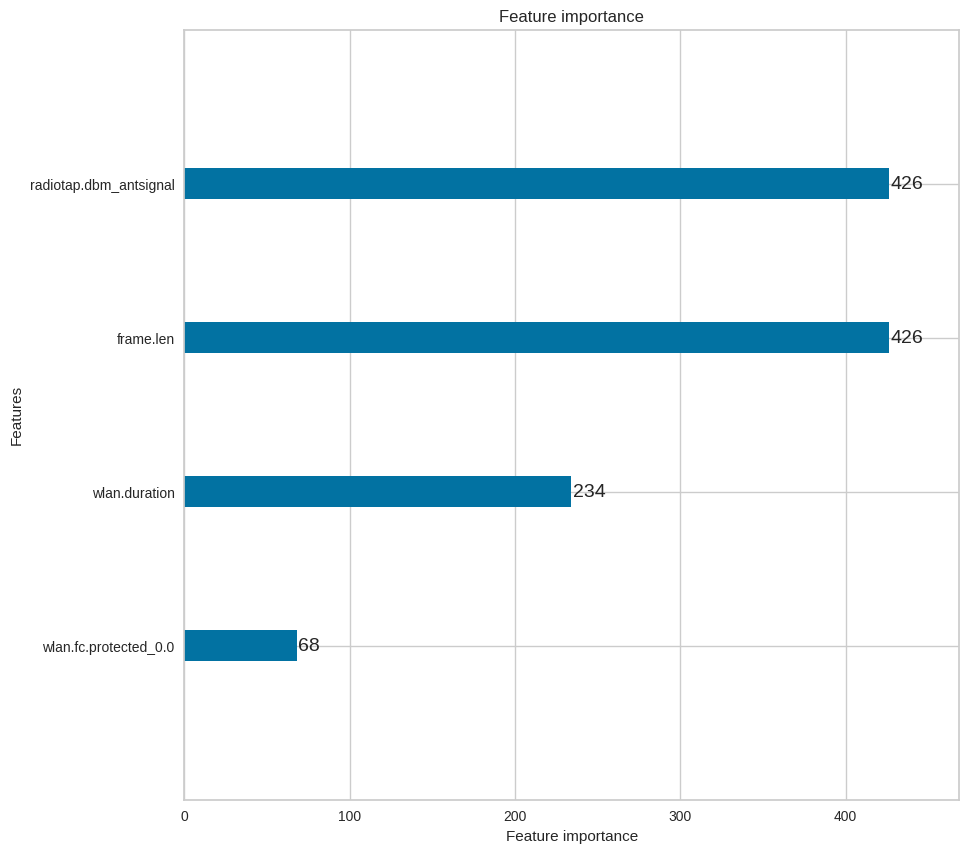

In [24]:
# Plot the importance of each feature on the trained model
lgb_plot_importance(model, (10, 10))

			Classification Report


              precision    recall  f1-score   support

      Normal    1.00000   0.99192   0.99595     24272
   Evil Twin    0.73333   1.00000   0.84615       539

    accuracy                        0.99210     24811
   macro avg    0.86667   0.99596   0.92105     24811
weighted avg    0.99421   0.99210   0.99269     24811

F1-Score: 0.84615

Confusion Matrix:



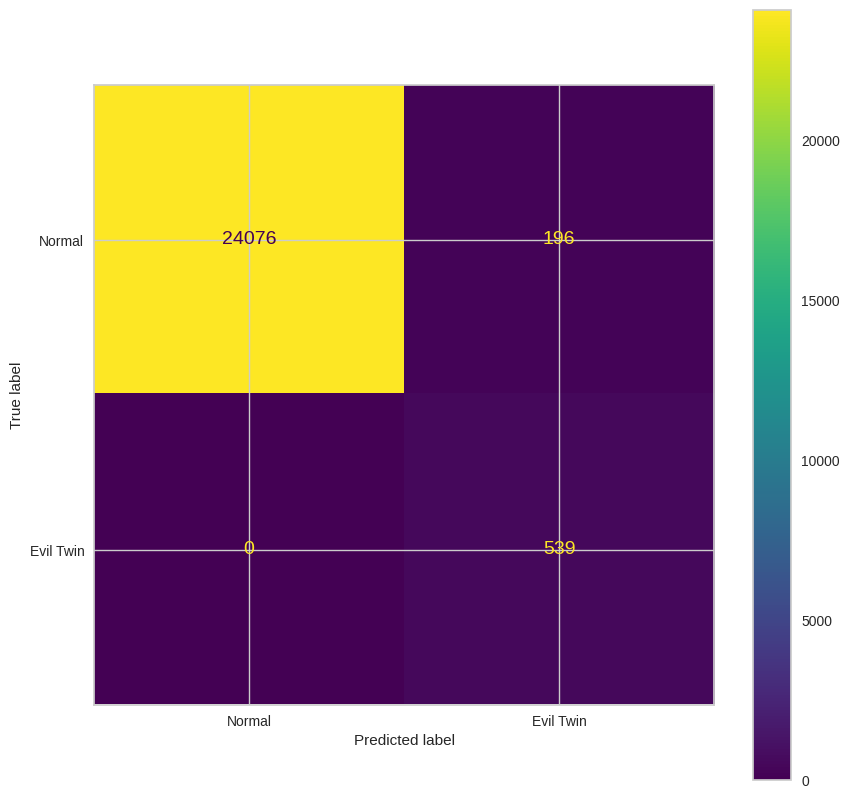

In [25]:
# LightGBM with optimized hyperparameters on test data
report_model(model, X_test_set_4, y_test, ['Normal', 'Evil Twin'], None)

### Using PyCaret for Automation

Only all columns only.

In [26]:
# Setting up PyCaret
setup = setup(data=train_df, target='Label', fold=5)

,Description,Value
0,Session id,608
1,Target,Label
2,Target type,Binary
3,Original data shape,"(3147, 24)"
4,Transformed data shape,"(3147, 24)"
5,Transformed train set shape,"(2202, 24)"
6,Transformed test set shape,"(945, 24)"
7,Numeric features,23
8,Preprocess,True
9,Imputation type,simple


In [27]:
# Compare the different models
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9941,0.9984,0.9943,0.9910,0.9926,0.9877,0.9877,0.0380
gbc,Gradient Boosting Classifier,0.9932,0.9983,0.9989,0.9844,0.9916,0.9858,0.9859,0.0940
rf,Random Forest Classifier,0.9927,0.9975,0.9966,0.9854,0.9910,0.9849,0.9850,0.1300
xgboost,Extreme Gradient Boosting,0.9927,0.9984,0.9955,0.9865,0.9910,0.9849,0.9849,0.0820
dt,Decision Tree Classifier,0.9918,0.9922,0.9943,0.9854,0.9898,0.9830,0.9831,0.0200
ada,Ada Boost Classifier,0.9914,0.9976,0.9943,0.9843,0.9893,0.9821,0.9821,0.0660
et,Extra Trees Classifier,0.9914,0.9961,0.9909,0.9876,0.9892,0.9820,0.9821,0.1180
svm,SVM - Linear Kernel,0.9882,0.0000,0.9932,0.9778,0.9854,0.9755,0.9756,0.0160
ridge,Ridge Classifier,0.9882,0.0000,0.9909,0.9798,0.9853,0.9755,0.9755,0.0160
lda,Linear Discriminant Analysis,0.9882,0.9916,0.9909,0.9798,0.9853,0.9755,0.9755,0.0220


In [28]:
# Select one of the templates to generate
# Here 'lightgbm' will be used
creat_model = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9932,0.9978,0.9944,0.9888,0.9915,0.9859,0.9859
1,0.9887,0.9963,0.9830,0.9886,0.9858,0.9763,0.9763
2,0.9932,0.9988,1.0000,0.9832,0.9915,0.9858,0.9859
3,0.9977,1.0000,0.9943,1.0000,0.9972,0.9953,0.9953
4,0.9977,0.9994,1.0000,0.9944,0.9972,0.9953,0.9953
Mean,0.9941,0.9984,0.9943,0.9910,0.9926,0.9877,0.9877
Std,0.0034,0.0013,0.0062,0.0057,0.0043,0.0071,0.0071


In [29]:
# Evaluate the selected model
evaluate_model(creat_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [30]:
# Optimize the hyperparameters of the generated model
tuned = tune_model(creat_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9955,0.9977,1.0000,0.9888,0.9944,0.9906,0.9906
1,0.9864,0.9978,0.9886,0.9775,0.9831,0.9717,0.9717
2,0.9909,0.9989,0.9943,0.9831,0.9887,0.9811,0.9811
3,0.9977,1.0000,1.0000,0.9944,0.9972,0.9953,0.9953
4,0.9932,0.9996,1.0000,0.9832,0.9915,0.9858,0.9859
Mean,0.9927,0.9988,0.9966,0.9854,0.9910,0.9849,0.9849
Std,0.0039,0.0009,0.0045,0.0057,0.0049,0.0081,0.0081


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


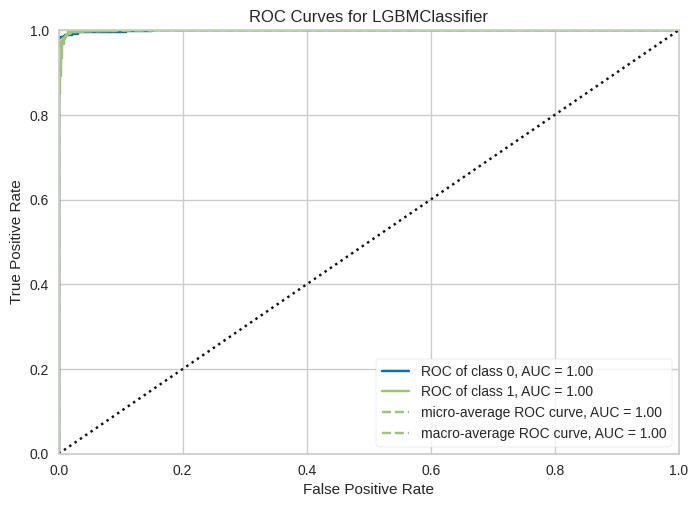

In [31]:
# ROC curve
plot_model(creat_model)

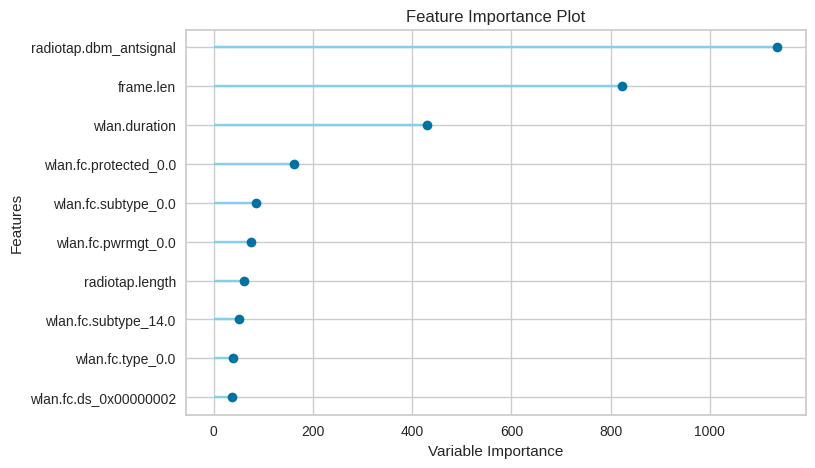

In [32]:
# Feature importance
plot_model(creat_model, plot='feature')

In [33]:
# Save the model
save_model(creat_model, f'{models_path}lightgbm_all_pycaret');

Transformation Pipeline and Model Successfully Saved


			Classification Report


              precision    recall  f1-score   support

      Normal    0.99988   0.99300   0.99642     24272
   Evil Twin    0.75921   0.99443   0.86104       539

    accuracy                        0.99303     24811
   macro avg    0.87954   0.99372   0.92873     24811
weighted avg    0.99465   0.99303   0.99348     24811

F1-Score: 0.86104

Confusion Matrix:



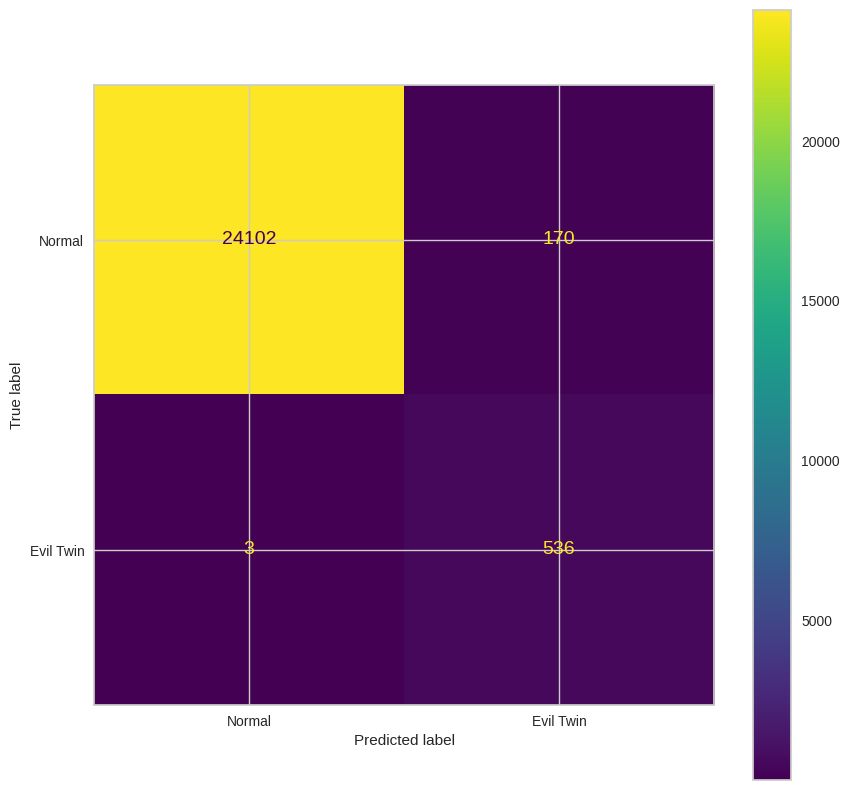

In [34]:
# LightGBM with optimized hyperparameters on test data
report_model(creat_model, X_test, y_test, ['Normal', 'Evil Twin'], None)